# Predict whether a video game will be a blockbuster or not
Authors: Niccolò Morabito & Md Jamiur Rahman Rifat

In [ ]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

# cross validation for HP
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score,auc, f1_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_FOLDER_PATH = "/content/drive/MyDrive/ML_Project/"
DATASET_PATH = PROJECT_FOLDER_PATH + "data/video_games.csv"
TRAINSET_PATH = PROJECT_FOLDER_PATH + "data/train_video_games.csv"
TESTSET_PATH = PROJECT_FOLDER_PATH + "data/test_video_games.csv"

TARGET_FEATURE = "Metrics.Review Score"
drop_correlated_features = False
feature_selection = False
feature_selection_threshold= 1

#Import data

In [ ]:
df = pd.read_csv(DATASET_PATH, header=0)
print(df.shape)
pd.set_option('display.max_columns', None)
df.head(5)

(1212, 36)


,Title,Features.Handheld?,Features.Max Players,Features.Multiplatform?,Features.Online?,Metadata.Genres,Metadata.Licensed?,Metadata.Publishers,Metadata.Sequel?,Metrics.Review Score,Metrics.Sales,Metrics.Used Price,Release.Console,Release.Rating,Release.Re-release?,Release.Year,Length.All PlayStyles.Average,Length.All PlayStyles.Leisure,Length.All PlayStyles.Median,Length.All PlayStyles.Polled,Length.All PlayStyles.Rushed,Length.Completionists.Average,Length.Completionists.Leisure,Length.Completionists.Median,Length.Completionists.Polled,Length.Completionists.Rushed,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,4.69,24.95,Nintendo DS,E,True,2004,22.716667,31.900000,24.483333,57,14.300000,29.766667,35.033333,30.000000,20,22.016667,24.916667,29.966667,25.000000,16,18.333333,14.333333,18.316667,14.500000,21,9.700000
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,0.56,14.95,Sony PSP,E,True,2004,10.100000,11.016667,10.000000,5,9.516667,0.000000,0.000000,0.000000,0,0.000000,9.750000,9.866667,9.750000,2,9.616667,10.333333,11.083333,10.000000,3,9.583333
2,WarioWare Touched!,True,2,True,True,"Action,Racing / Driving,Sports",True,Nintendo,True,81,0.54,22.95,Nintendo DS,E,True,2004,4.566667,11.566667,2.500000,57,2.266667,10.000000,14.100000,7.250000,16,6.800000,3.850000,5.666667,3.333333,11,2.783333,1.916667,2.933333,1.833333,30,1.433333
3,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,0.49,12.95,Sony PSP,E,True,2004,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,0.45,14.95,Nintendo DS,E,True,2004,13.250000,48.383333,10.000000,37,7.066667,72.566667,78.866667,72.566667,2,66.283333,12.766667,17.316667,12.500000,12,10.483333,8.350000,11.083333,8.000000,23,5.333333


#Split data into training and test sets

In [ ]:
train, test = train_test_split(df, test_size=.25)
train.to_csv(TRAINSET_PATH,  index=False)
test.to_csv(TESTSET_PATH, index=False)

In [ ]:
train_df=pd.read_csv(TRAINSET_PATH, header=0)
# check the null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Title                          909 non-null    object 
 1   Features.Handheld?             909 non-null    bool   
 2   Features.Max Players           909 non-null    int64  
 3   Features.Multiplatform?        909 non-null    bool   
 4   Features.Online?               909 non-null    bool   
 5   Metadata.Genres                909 non-null    object 
 6   Metadata.Licensed?             909 non-null    bool   
 7   Metadata.Publishers            709 non-null    object 
 8   Metadata.Sequel?               909 non-null    bool   
 9   Metrics.Review Score           909 non-null    int64  
 10  Metrics.Sales                  909 non-null    float64
 11  Metrics.Used Price             909 non-null    float64
 12  Release.Console                909 non-null    obj

#EDA

In [ ]:
train_df.describe()

,Features.Max Players,Metrics.Review Score,Metrics.Sales,Metrics.Used Price,Release.Year,Length.All PlayStyles.Average,Length.All PlayStyles.Leisure,Length.All PlayStyles.Median,Length.All PlayStyles.Polled,Length.All PlayStyles.Rushed,Length.Completionists.Average,Length.Completionists.Leisure,Length.Completionists.Median,Length.Completionists.Polled,Length.Completionists.Rushed,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
count,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,1.661166,69.167217,0.507602,17.408746,2006.817382,13.888926,27.833828,11.280638,45.755776,9.504327,20.554034,27.259039,19.394353,5.928493,16.942849,13.194133,20.056472,12.494921,14.579758,10.639696,8.599523,11.347066,8.373231,25.341034,7.080950
std,1.216462,12.665146,1.087806,5.101147,1.040843,18.622597,55.579727,13.158986,158.844998,10.630074,47.025609,64.710229,43.840874,20.840393,39.621989,26.049130,47.773969,25.359531,60.921137,22.807007,9.795862,14.714191,9.546024,87.461447,7.996458
min,1.000000,19.000000,0.010000,4.950000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,61.000000,0.090000,14.950000,2006.000000,4.000000,5.116667,3.750000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316667,0.316667,0.250000,1.000000,0.266667
50%,1.000000,70.000000,0.220000,17.950000,2007.000000,9.116667,12.000000,8.000000,6.000000,6.816667,6.000000,6.483333,6.000000,1.000000,6.000000,7.250000,8.000000,7.000000,1.000000,6.250000,6.666667,8.116667,6.666667,3.000000,5.383333
75%,2.000000,79.000000,0.460000,17.950000,2008.000000,16.816667,28.616667,14.000000,25.000000,11.950000,21.383333,27.116667,20.250000,4.000000,18.000000,16.083333,21.400000,15.000000,6.000000,13.383333,11.116667,14.816667,10.516667,14.000000,9.583333
max,8.000000,98.000000,14.660000,49.950000,2008.000000,191.250000,476.266667,126.000000,2300.000000,76.300000,617.416667,676.133333,617.416667,379.000000,558.700000,291.000000,478.933333,291.000000,1100.000000,291.000000,72.383333,135.583333,70.000000,1100.000000,70.000000


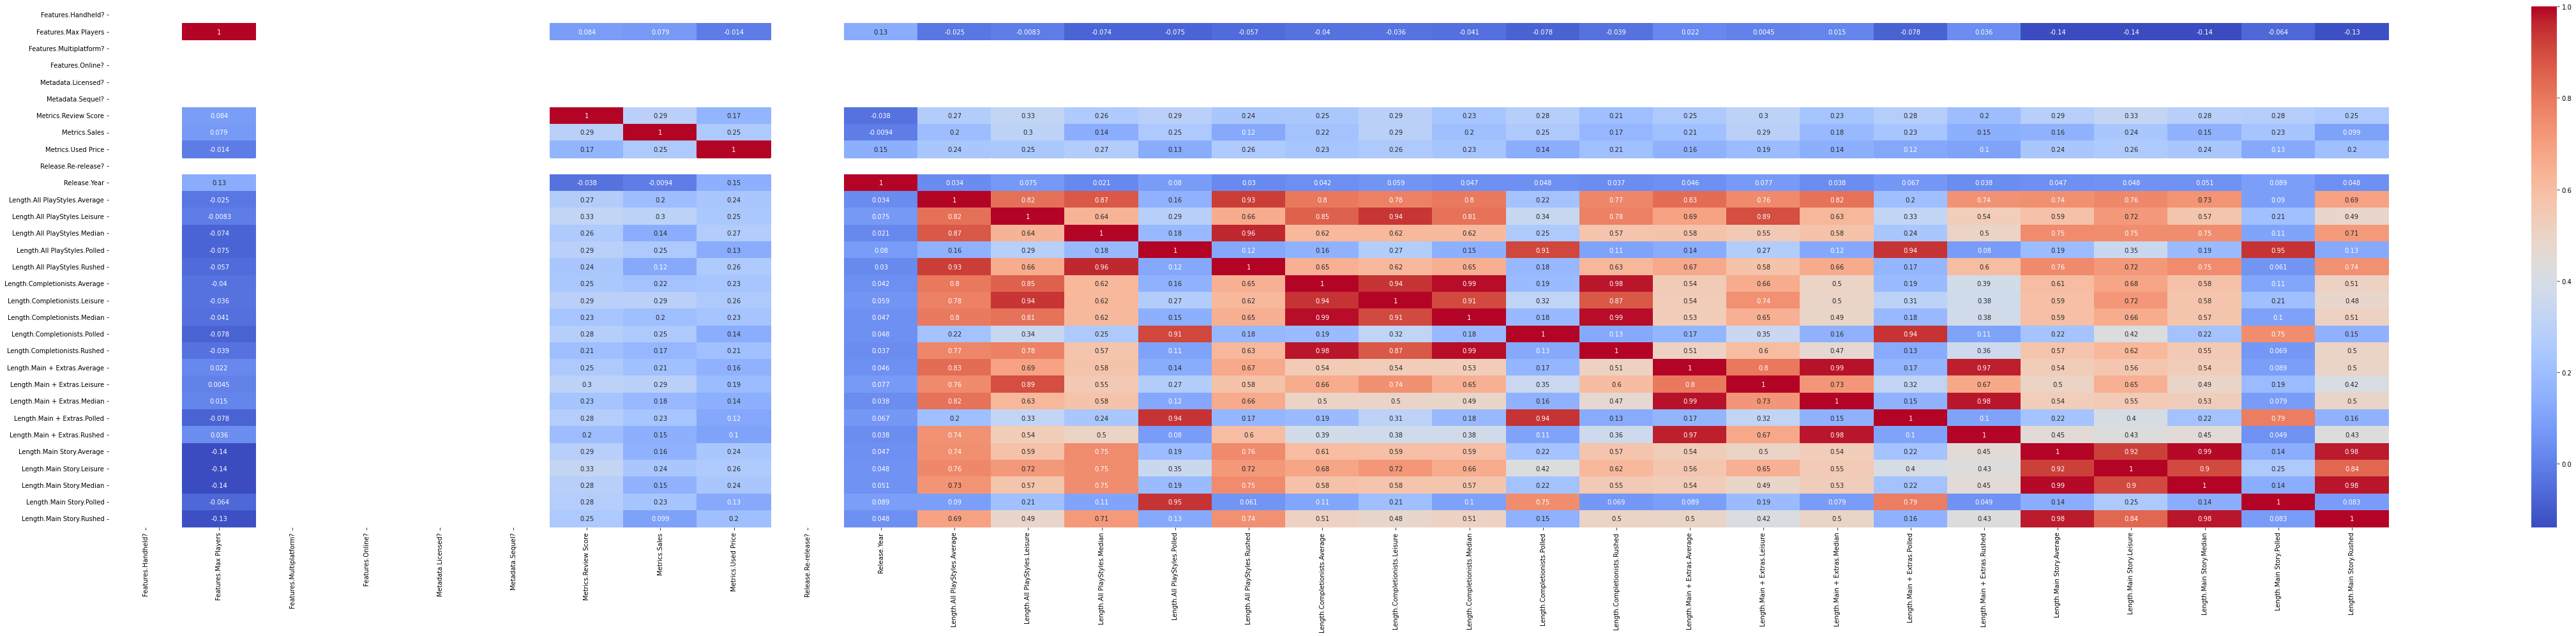

In [ ]:
plt.rcParams["figure.figsize"] = (80, 15)
sns.heatmap(train_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [ ]:
## if you want to remove the correlated features
if (drop_correlated_features):
    corr_matrix = train_df.corr().abs()
    upperMatrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Find index of feature columns with correlation greater than 0.95
    corrFutures = [column for column in upperMatrix.columns if any(upperMatrix[column] > 0.95)]
    print(corrFutures)
    train_df.drop(columns=corrFutures)
else:
    corrFutures = []

In [ ]:
drop_correlated_features

False

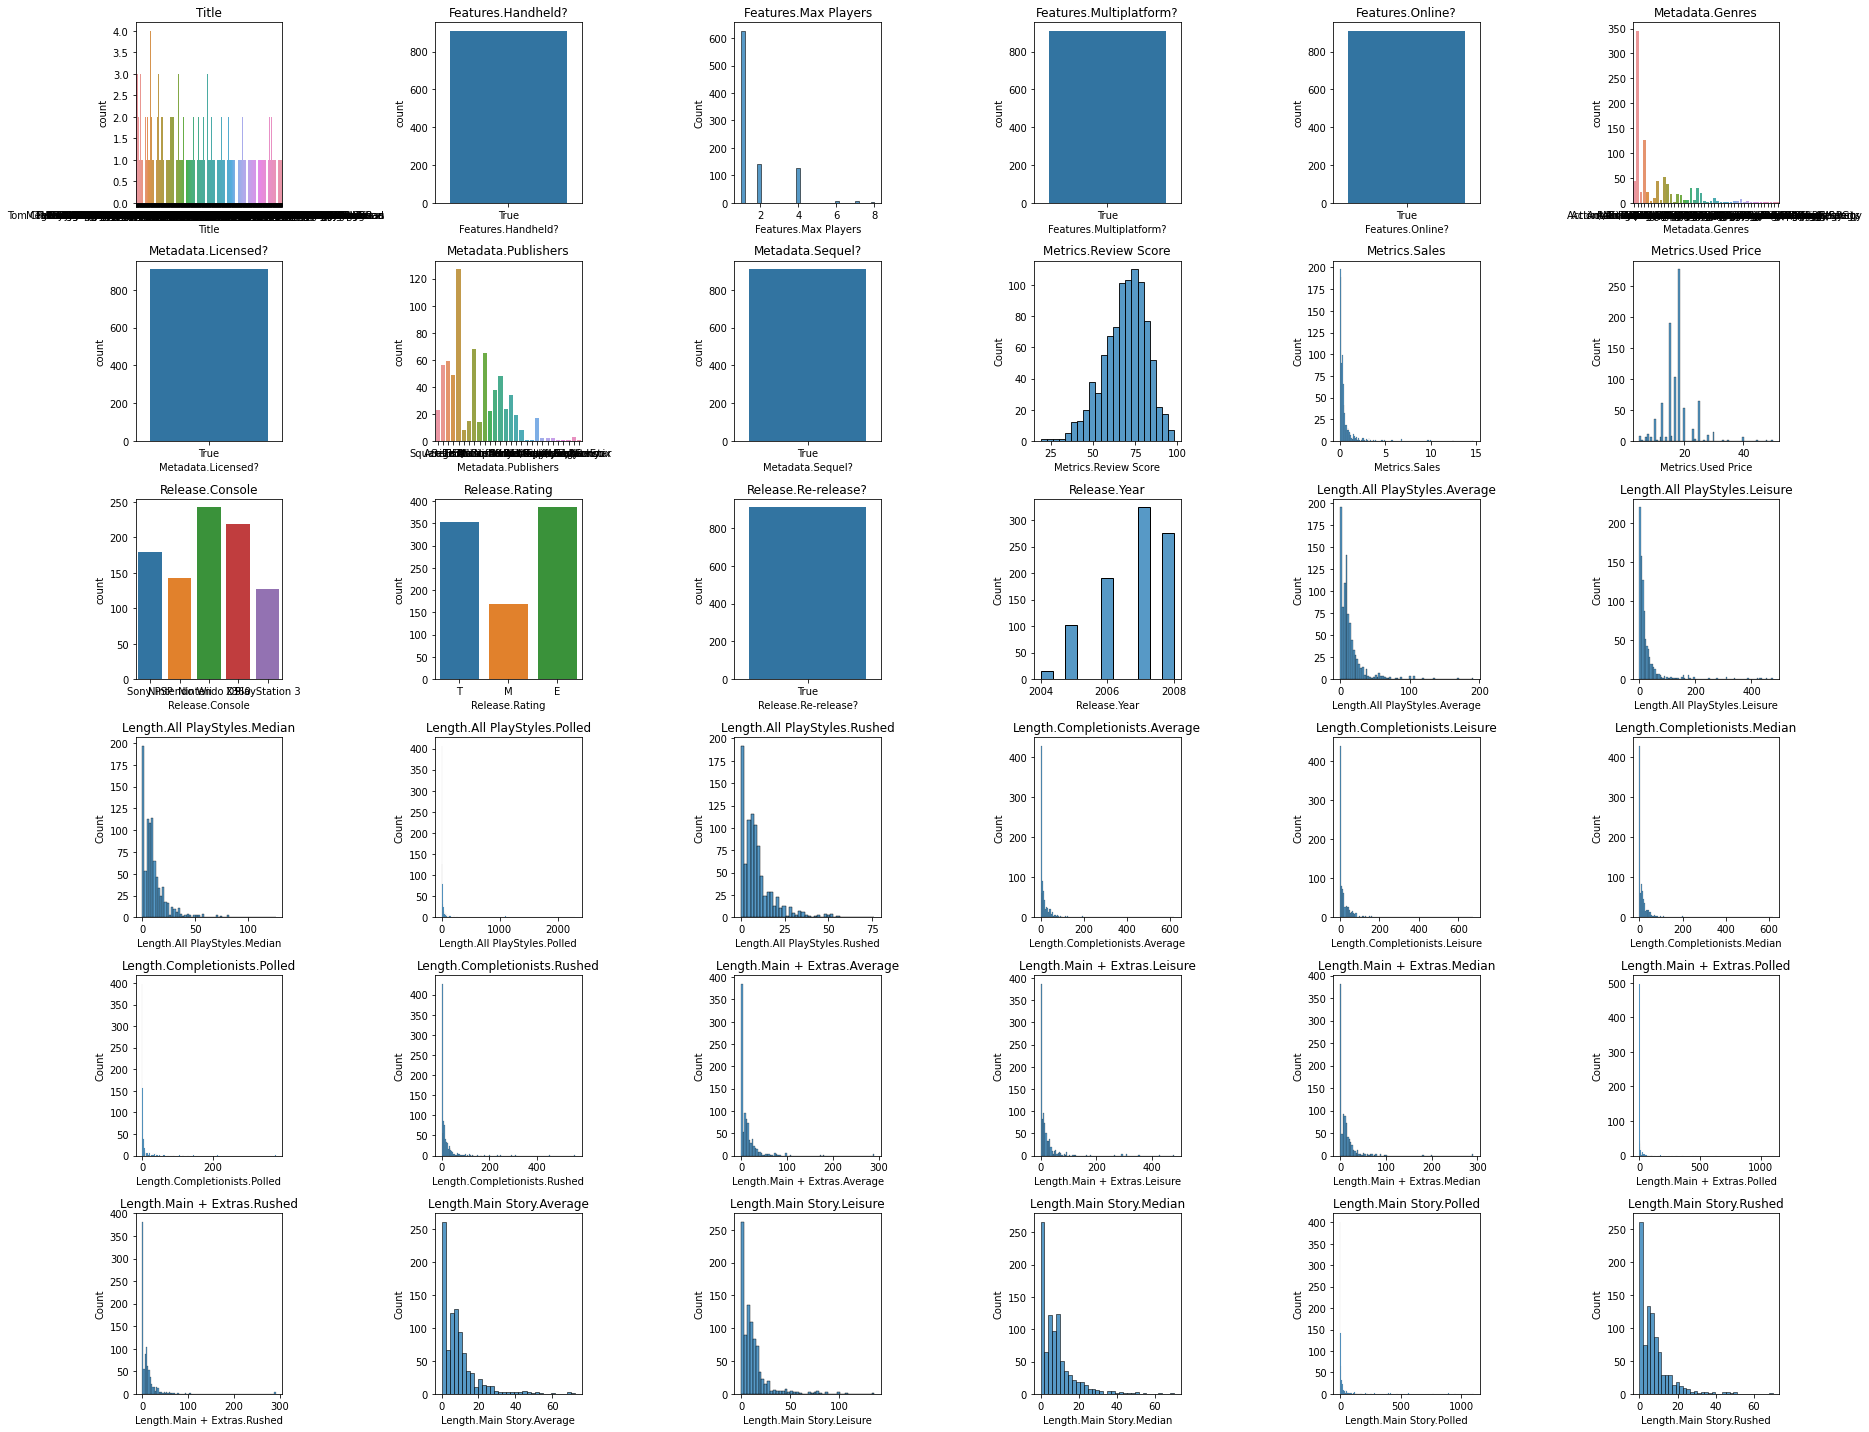

In [ ]:
fig, axes = plt.subplots(6,6,figsize=(26,20))

for i, c in enumerate(train_df.columns):
  ax = axes.reshape(-1)[i]
  if train_df[c].dtype.kind == 'O' or train_df[c].dtype.kind == 'b':
    a = sns.countplot(x=c,data=train_df, ax=ax)
  else:
    b = sns.histplot(x=c,data=train_df, ax=ax)
  t = ax.set_title(c)

plt.tight_layout()

In [ ]:
# DELETION OF COLUMNS

# title is an unique identifier
train_df.drop('Title', axis=1, inplace=True)
# the following features are useless because all the records have true for each of them
train_df.drop('Features.Multiplatform?', axis=1, inplace=True)
train_df.drop('Metadata.Sequel?', axis=1, inplace=True)
train_df.drop('Features.Handheld?', axis=1, inplace=True)
train_df.drop('Metadata.Licensed?', axis=1, inplace=True)
train_df.drop('Features.Online?', axis=1, inplace=True)
train_df.drop('Release.Re-release?', axis=1, inplace=True)

train_df.drop('Release.Year', axis=1, inplace=True)
useless_feature_list = ['Title','Features.Multiplatform?','Metadata.Sequel?','Features.Handheld?','Metadata.Licensed?','Features.Online?','Release.Re-release?','Release.Year']
delete_feature_list = corrFutures +useless_feature_list
joblib.dump(delete_feature_list, PROJECT_FOLDER_PATH+'output/delete_list.pkl')

['/content/drive/MyDrive/ML_Project/output/delete_list.pkl']

#Separate numeric and categorical attributes


In [ ]:
input_attribs = (train_df.columns).tolist()
num_attribs = [i for i in train_df.select_dtypes(include=[np.number])]
cat_attribs = list(set(input_attribs)-set(num_attribs))
num_attribs.remove(TARGET_FEATURE)

print(f"""There are {len(num_attribs)} numerical features ({num_attribs})
  and {len(cat_attribs)} categorical features ({cat_attribs})""")

## Dump cat_attribs and num_attribs name
joblib.dump(num_attribs, PROJECT_FOLDER_PATH+'output/num_attribs.pkl')
joblib.dump(cat_attribs, PROJECT_FOLDER_PATH+'output/cat_attribs.pkl')

There are 23 numerical features (['Features.Max Players', 'Metrics.Sales', 'Metrics.Used Price', 'Length.All PlayStyles.Average', 'Length.All PlayStyles.Leisure', 'Length.All PlayStyles.Median', 'Length.All PlayStyles.Polled', 'Length.All PlayStyles.Rushed', 'Length.Completionists.Average', 'Length.Completionists.Leisure', 'Length.Completionists.Median', 'Length.Completionists.Polled', 'Length.Completionists.Rushed', 'Length.Main + Extras.Average', 'Length.Main + Extras.Leisure', 'Length.Main + Extras.Median', 'Length.Main + Extras.Polled', 'Length.Main + Extras.Rushed', 'Length.Main Story.Average', 'Length.Main Story.Leisure', 'Length.Main Story.Median', 'Length.Main Story.Polled', 'Length.Main Story.Rushed'])
  and 4 categorical features (['Release.Console', 'Metadata.Genres', 'Metadata.Publishers', 'Release.Rating'])


['/content/drive/MyDrive/ML_Project/output/cat_attribs.pkl']

In [ ]:
# considering 0 values as null in order to replace them by imputation
train_df[num_attribs] = train_df[num_attribs].replace(0, np.nan)

# Imputation and scaling

In [ ]:
num_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('std_scaler', StandardScaler())
])

preprocessing = ColumnTransformer([('numerical', num_pipeline, num_attribs)],
    remainder='passthrough', verbose=True)

train_df = train_df[num_attribs+cat_attribs+[TARGET_FEATURE]]

train_df = pd.DataFrame(preprocessing.fit_transform(train_df), columns=train_df.columns)

joblib.dump(preprocessing, PROJECT_FOLDER_PATH+'output/preprocessing.pkl')

[ColumnTransformer] ..... (1 of 2) Processing numerical, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


['/content/drive/MyDrive/ML_Project/output/preprocessing.pkl']

# Visualization and deletion of outliers

(909, 28)
(898, 28)


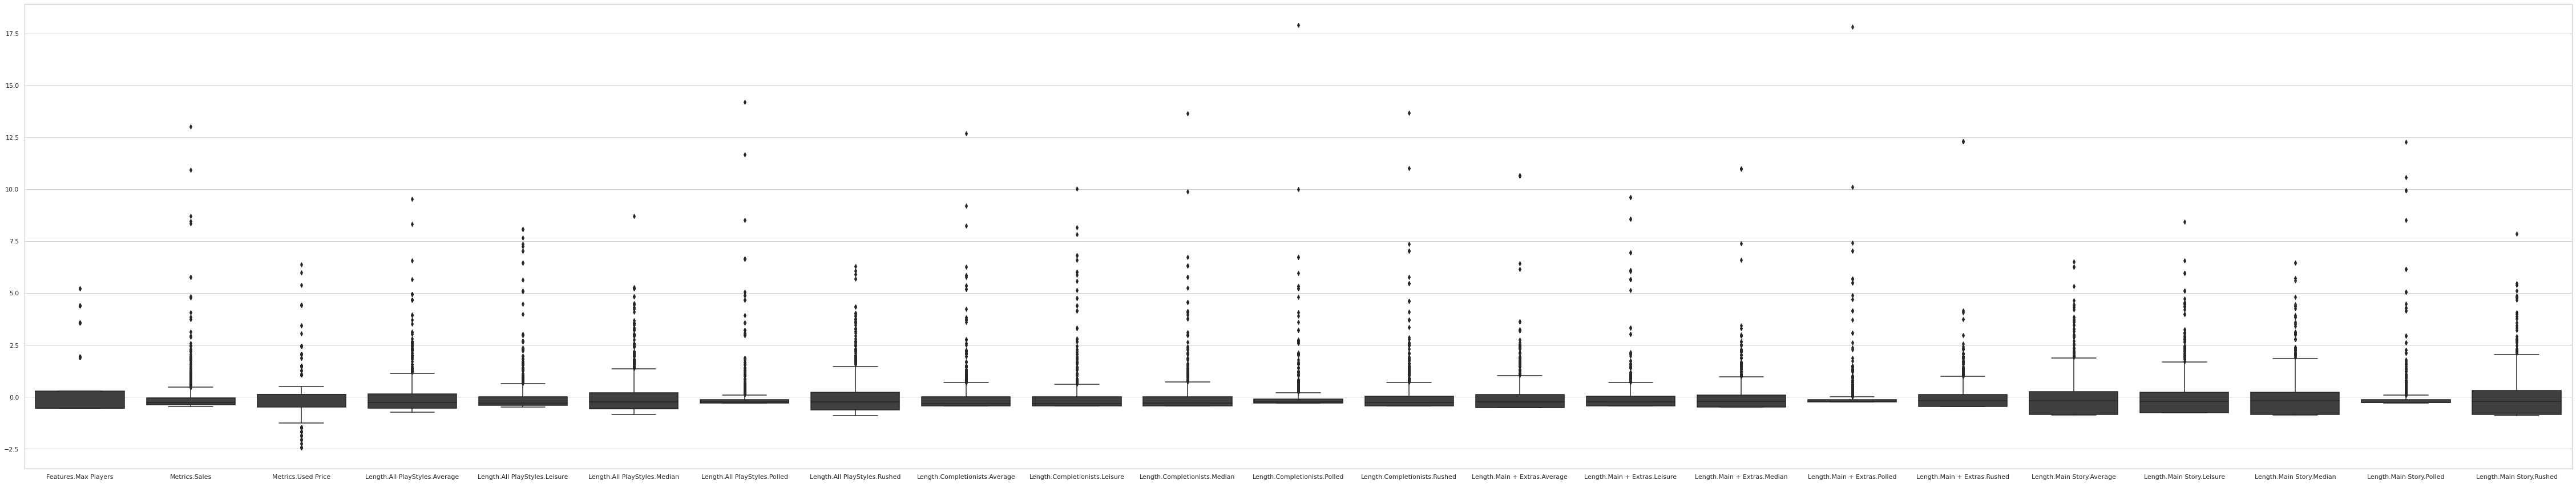

In [ ]:
plt.rcParams["figure.figsize"] = (80, 15)
plt.rcParams["xtick.labelsize"] = 15
print(train_df.shape)
sns.set(style="whitegrid")
ax = sns.boxplot(data=train_df[num_attribs], color=".25")

# Remove outliers
threshold=10
for att in num_attribs:
    train_df = train_df.loc[(train_df[att]).abs() < threshold]
    #df[(np.abs(stats.zscore(df[0])) < 3)] #actual code for the zscore calculation

train_df=train_df.reset_index(drop=True)
print(train_df.shape)

# Separate input and target features

In [ ]:
X_train = train_df.drop(TARGET_FEATURE, axis=1)
y_train = train_df[TARGET_FEATURE]


# One hot encoding + final preprocessed data available for modeling

In [ ]:
print(len(set(X_train["Metadata.Genres"])))
print(len(set(X_train["Metadata.Publishers"])))
print(len(set(X_train["Release.Console"])))
print(len(set(X_train["Release.Rating"])))

44
29
5
3


In [ ]:
for feature in cat_attribs:
  # encode the publishers and genres columns splitting on ','
  if feature == 'Metadata.Publishers' or feature == 'Metadata.Genres':
    new_columns = X_train[feature].str.get_dummies(sep=',').add_prefix(feature[:-1] + "_")
  # encode all the remaining categorical features with "classic" one-hot encoding
  else:
    new_columns = pd.get_dummies(X_train[feature], prefix=feature)

  # add new columns and remove the original feature column
  X_train = pd.concat([X_train, new_columns], axis=1)
  X_train.drop([feature], axis=1, inplace=True)
print(X_train.shape)



(898, 57)


# Binning target variable

In [ ]:
# y_train = pd.cut(
#     y_train,
#     2,
#     labels=['no', 'yes']
# )
# pd.set_option('display.max_rows', 20)
# y_train.value_counts()

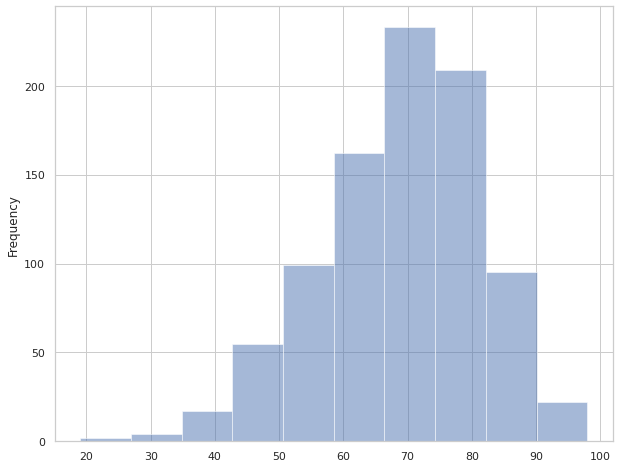

In [ ]:
ax = y_train.plot.hist(bins=10, alpha=0.5,figsize=(10, 8))

In [ ]:
# binning based on the domain knowledge and intuition
y_train = pd.Series( np.where(y_train >= 80, 'yes', 'no'))
y_train.value_counts()

no     693
yes    207
dtype: int64

# Feature selection

In [ ]:
# Select two features with highest anova statistics
chi2_selector = SelectKBest(f_classif, k='all')
chi2_selector.fit(X_train, y_train)

# Look at scores returned from the selector for each feature
feature_scores = pd.DataFrame(list(zip((X_train.columns).tolist(), chi2_selector.scores_, chi2_selector.pvalues_)), columns=['Feature Name', 'score', 'pval'])
feature_scores = feature_scores.sort_values(by=['score'], ascending=False)
feature_scores

,Feature Name,score,pval
1,Metrics.Sales,144.140775,6.666860e-31
4,Length.All PlayStyles.Leisure,114.676047,2.879279e-25
9,Length.Completionists.Leisure,112.498414,7.632729e-25
14,Length.Main + Extras.Leisure,93.853351,3.538690e-21
19,Length.Main Story.Leisure,92.455577,6.710029e-21
11,Length.Completionists.Polled,88.463630,4.195103e-20
8,Length.Completionists.Average,88.253392,4.621310e-20
16,Length.Main + Extras.Polled,86.996607,8.244809e-20
6,Length.All PlayStyles.Polled,85.353263,1.759828e-19
10,Length.Completionists.Median,81.674742,9.656553e-19


In [ ]:
## Select the features based on the scores
if (feature_selection):
    feature_scores = feature_scores.loc[feature_scores['score']>feature_selection_threshold]

    X_train = X_train[feature_scores['Feature Name'].tolist()]

final_attribs = (X_train.columns).tolist()
joblib.dump(final_attribs, PROJECT_FOLDER_PATH+'output/final_attribs.pkl')


['/content/drive/MyDrive/ML_Project/output/final_attribs.pkl']

# HP tuning

In [ ]:
''' DECISION TREE '''

possible_parameters = {
    'criterion' : ['gini', 'entropy'],
    'splitter'  : ['best', 'random'],
    'max_depth' : [None, 3, 8, 15, 25, 40, 60],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 3],
    'max_features' : ['auto', 'sqrt', 'log2']
}

dt_clf = GridSearchCV(
    tree.DecisionTreeClassifier(), possible_parameters, scoring='accuracy', n_jobs=-1
)

dt_clf.fit(X_train, y_train)

print(f"Best params: {dt_clf.best_params_}")
print(f"Best score: {dt_clf.best_score_}")

Best params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 10, 'splitter': 'best'}
Best score: 0.8255555555555555


In [ ]:
## Drawing the decision tree
#tree.plot_tree(dt_clf.best_estimator_)
# Get the feature importance value
feature_scores = pd.DataFrame(list(zip((X_train.columns).tolist(), (dt_clf.best_estimator_).feature_importances_)), columns=['Feature Name', 'score'])
feature_scores = feature_scores.sort_values(by=['score'], ascending=False)
feature_scores

,Feature Name,score
21,Length.Main Story.Polled,0.290003
4,Length.All PlayStyles.Leisure,0.112648
1,Metrics.Sales,0.086925
13,Length.Main + Extras.Average,0.067025
22,Length.Main Story.Rushed,0.051225
14,Length.Main + Extras.Leisure,0.045436
29,Metadata.Genre_Sports,0.042339
19,Length.Main Story.Leisure,0.041672
20,Length.Main Story.Median,0.030914
32,Release.Console_Nintendo Wii,0.027182


In [ ]:
''' RANDOM FOREST '''

possible_parameters = {
    'n_estimators' : [100, 1000],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 3, 8, 15, 25, 40, 60],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 3],
    'max_features' : ['auto', 'sqrt', 'log2']
}

rf_clf = GridSearchCV(
    RandomForestClassifier(), possible_parameters, cv=3, n_jobs=-1, scoring='accuracy'
)

rf_clf.fit(X_train, y_train)

print(f"Best params: {rf_clf.best_params_}")
print(f"Best score: {rf_clf.best_score_}")

Best params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.8333333333333334


In [ ]:
''' MLPN '''

possible_parameters = {
    'activation' : ['logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [ (5,), (50,), (100,), (1000,)]
}

nn_clf = RandomizedSearchCV(
    MLPClassifier(max_iter=3000, learning_rate='adaptive'), possible_parameters, scoring='accuracy', n_jobs=-1
)

nn_clf.fit(X_train, y_train)

print(f"Best params: {nn_clf.best_params_}")
print(f"Best score: {nn_clf.best_score_}")

Best params: {'hidden_layer_sizes': (1000,), 'activation': 'logistic'}
Best score: 0.8277777777777778


In [ ]:
''' SUPPORT VECTOR MACHINE '''
from sklearn import preprocessing

possible_parameters = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svm_clf = GridSearchCV(
    svm.SVC(), possible_parameters, cv=3, n_jobs=-1, scoring='accuracy'
)

svm_clf.fit(X_train, y_train)

print(f"Best params: {svm_clf.best_params_}")
print(f"Best score: {svm_clf.best_score_}")

Best params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best score: 0.8255555555555555


In [ ]:
''' XG BOOST '''
from sklearn import preprocessing
import xgboost as xgb
possible_parameters = {
    "n_estimators": [1, 10, 100, 1000],
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    
}

xgb_clf = GridSearchCV(
    xgb.XGBClassifier(), possible_parameters, cv=3, n_jobs=-1, scoring='accuracy'
)

xgb_clf.fit(X_train.astype("double"), y_train)

print(f"Best params: {xgb_clf.best_params_}")
print(f"Best score: {xgb_clf.best_score_}")

# Best Model Selection & Evaluation on Train Set

 pred/true         | Positive Prediction | Negative Prediction
-------------------|---------------------|---------------------
Positive Class       | True Positive(TP) | False Negative (FN)
Negative Class       | False Positive(FP)| True Negative (TN)

In [ ]:
# set the name of the best model
best_model = xgb_clf

label= str(xgb_clf.estimator).split("(")[0]
if (label == 'XGBClassifier'):
  X_train = X_train.astype("double")
else:
  print('no')

X_train.shape

In [ ]:
# Create classification report

y_pred = best_model.predict(X_train)
#y_pred = best_model.predict(X_train)
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_train, y_pred))

In [ ]:
## Make the confusion matrix
confusion_matrix(y_train, y_pred)

In [ ]:
yhat = best_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = yhat[:, 1]
# calculate scores
ns_probs = [0 for _ in range(len(y_train))]
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print(label+': ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs, pos_label="yes")
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs, pos_label="yes")
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label=label)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:

# Plot Precision/ Recall graph
lr_precision, lr_recall, _ = precision_recall_curve(y_train, lr_probs, pos_label=  'yes')
# plot the precision-recall curves
no_skill = len(y_train[y_train==1]) / len(y_train)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label=label)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Save the best model
print(best_model)
joblib.dump(best_model, PROJECT_FOLDER_PATH+'output/best_model.pkl')



---



---

